<a href="https://colab.research.google.com/github/wdgstl/ML4VA-UNET/blob/main/AtheroDataProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install boto3

# Pulling Data From S3 using Boto3

In [ ]:
from google.colab import userdata
import boto3
import os

AWS_ACCESS_KEY_ID = userdata.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = userdata.get('AWS_SECRET_ACCESS_KEY')
bucket_name = 'atherosclerosis-unet'
path_to_raw = 'images/raw_histology/'
path_to_mask = 'images/segmented_histology/'

s3 = boto3.client('s3',
                  aws_access_key_id=AWS_ACCESS_KEY_ID,
                  aws_secret_access_key=AWS_SECRET_ACCESS_KEY)

local_dir = 'downloaded_raw_images'
os.makedirs(local_dir, exist_ok=True)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path_to_raw)

print('Downloading Raw Histology')
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.tif'):
        file_name = os.path.basename(key)
        local_path = os.path.join(local_dir, file_name)
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded: {file_name}')


local_dir = 'downloaded_mask_images'
os.makedirs(local_dir, exist_ok=True)

response = s3.list_objects_v2(Bucket=bucket_name, Prefix=path_to_mask)


print('Downloading Mask Histology')
for obj in response.get('Contents', []):
    key = obj['Key']
    if key.endswith('.tif'):
        file_name = os.path.basename(key)
        local_path = os.path.join(local_dir, file_name)
        s3.download_file(bucket_name, key, local_path)
        print(f'Downloaded: {file_name}')


Downloaded: 8390-1 3-10 4X.tif
Downloaded: 8390-1 3-11 4X.tif
Downloaded: 8390-1 3-12 4X.tif
Downloaded: 8390-1 3-7 4X.tif
Downloaded: 8390-1 3-8 4X.tif
Downloaded: 8390-1 3-9 4X.tif
Downloaded: 8390-1 4-1 4X.tif
Downloaded: 8390-1 4-10 4X.tif
Downloaded: 8390-1 4-11 4X.tif
Downloaded: 8390-1 4-12 4X.tif
Downloaded: 8390-1 4-2 4X.tif
Downloaded: 8390-1 4-3 4X.tif
Downloaded: 8390-1 4-4 4X.tif
Downloaded: 8390-1 4-5 4X.tif
Downloaded: 8390-1 4-6 4X.tif
Downloaded: 8390-1 4-7 4X.tif
Downloaded: 8390-1 4-8 4X.tif
Downloaded: 8390-1 4-9 4X.tif
Downloaded: 8390-1 5-1 4X.tif
Downloaded: 8390-1 5-2 4X.tif
Downloaded: 8390-1 5-3 4X.tif
Downloaded: 8390-2 4-1 4X.tif
Downloaded: 8390-2 4-10 4X.tif
Downloaded: 8390-2 4-11 4X.tif
Downloaded: 8390-2 4-12 4X.tif
Downloaded: 8390-2 4-2 4X.tif
Downloaded: 8390-2 4-3 4X.tif
Downloaded: 8390-2 4-4 4X.tif
Downloaded: 8390-2 4-5 4X.tif
Downloaded: 8390-2 4-6 4X.tif
Downloaded: 8390-2 4-7 4X.tif
Downloaded: 8390-2 4-8 4X.tif
Downloaded: 8390-2 4-9 4X.tif
D

In [ ]:
def download_all_objects(bucket_name, prefix, local_dir):
    os.makedirs(local_dir, exist_ok=True)
    print(f'Downloading from {prefix} to {local_dir}')

    continuation_token = None
    while True:
        if continuation_token:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
        else:
            response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

        for obj in response.get('Contents', []):
            key = obj['Key']
            if key.endswith('.tif'):
                file_name = os.path.basename(key)
                local_path = os.path.join(local_dir, file_name)
                s3.download_file(bucket_name, key, local_path)
                print(f'Downloaded: {file_name}')

        if response.get('IsTruncated'):  # There are more files to fetch
            continuation_token = response.get('NextContinuationToken')
        else:
            break

# Download raw images
download_all_objects(bucket_name, path_to_raw, 'downloaded_raw_images')

# Download mask images
download_all_objects(bucket_name, path_to_mask, 'downloaded_mask_images')


# Data Preprocessing Pipeline

In [ ]:
import matplotlib.pyplot as plt

def show_image_and_mask(image, mask):
    plt.figure(figsize=(10, 5))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

    # Show mask (grayscale)
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # squeeze in case shape is (H, W, 1)
    plt.title('Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def resize_and_pad(image, target_size=(256, 256), pad_value=0):
    target_h, target_w = target_size
    h, w = image.shape[:2]

    # Compute scale while preserving aspect ratio
    scale = min(target_w / w, target_h / h)
    new_w = int(w * scale)
    new_h = int(h * scale)

    # Resize the image
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # Compute padding amounts
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left

    # Apply padding
    padded = cv2.copyMakeBorder(
        resized,
        pad_top, pad_bottom,
        pad_left, pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=pad_value
    )

    return padded


In [ ]:
def resize_with_aspect_ratio(type, x, size, direction):
    if type == 'mask':
        aspect_ratio = x.shape[1] / x.shape[0]
        new_size = (size)
        if aspect_ratio > 1:
            new_width = new_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = new_size[1]
            new_width = int(new_height * aspect_ratio)
        if direction == 'up':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        if direction == 'down':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_image = np.zeros((new_size[1], new_size[0]), dtype=np.uint8) * 255
        padding_left = (new_size[0] - new_width) // 2
        padding_top = (new_size[1] - new_height) // 2
        padded_image[padding_top:padding_top + new_height, padding_left:padding_left + new_width] = resized_image
    if type == 'image':
        aspect_ratio = x.shape[1] / x.shape[0]
        new_size = (size)
        if aspect_ratio > 1:
            new_width = new_size[0]
            new_height = int(new_width / aspect_ratio)
        else:
            new_height = new_size[1]
            new_width = int(new_height * aspect_ratio)
        if direction == 'up':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        if direction == 'down':
            resized_image = cv2.resize(x, (new_width, new_height), interpolation=cv2.INTER_AREA)
        padded_image = np.ones((new_size[1], new_size[0], 3), dtype=np.uint8) * 255
        padding_left = (new_size[0] - new_width) // 2
        padding_top = (new_size[1] - new_height) // 2
        padded_image[padding_top:padding_top + new_height, padding_left:padding_left + new_width] = resized_image
    return padded_image

In [ ]:
import cv2
import numpy as np
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    # x = resize_and_pad(x)
    x = resize_with_aspect_ratio('image', x, (256, 256), 'down')

    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    # x = resize_and_pad(x, pad_value=0)  ## (h, w)
    x = resize_with_aspect_ratio('mask', x, (256, 256), 'down')  ## (h, w)
    x = x / 255.0  ## (h, w)
    x = x.astype(np.float32)  ## (h, w)
    x = np.expand_dims(x, axis=-1)  ## (h, w, 1)
    return x


In [ ]:
im = read_image('/content/downloaded_raw_images/8390-1 3-10 4X.tif')

im.shape

(256, 256, 3)

In [ ]:
mask = read_mask('/content/downloaded_mask_images/8390-1 3-10 4X_mask.tif')

mask.shape

(256, 256, 1)

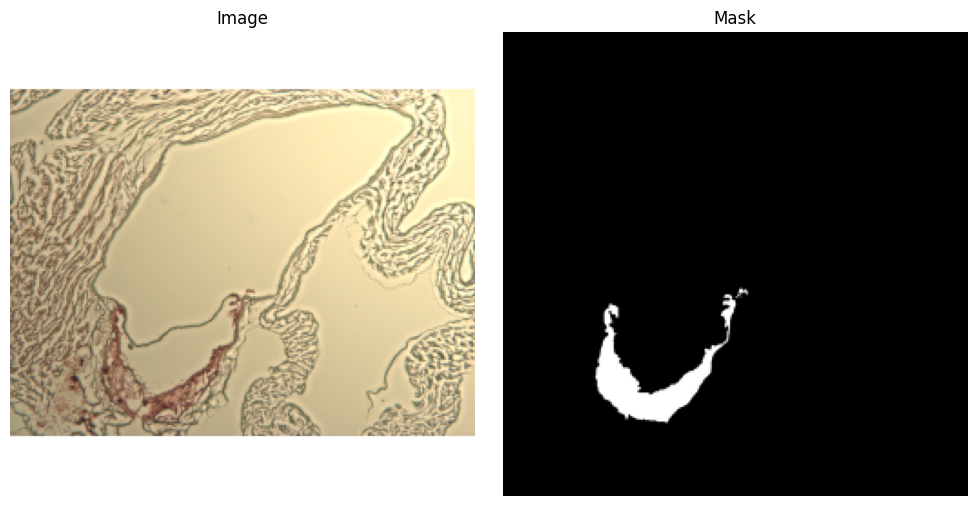

In [ ]:
show_image_and_mask(im, mask)

In [ ]:
def load_dataset(image_dir, mask_dir, target_size=None):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    X = []
    y = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)
        if img_path.endswith('.tif') and mask_path.endswith('.tif'):
          image = read_image(img_path)
          mask = read_mask(mask_path)

          X.append(image)
          y.append(mask)

    X = np.array(X)  # (N, H, W, 3)
    y = np.array(y)  # (N, H, W, 1)

    return X, y


In [ ]:
from sklearn.model_selection import train_test_split
import os
X, y = load_dataset('/content/downloaded_raw_images/', '/content/downloaded_mask_images')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(799, 256, 256, 3)
(100, 256, 256, 3)
(100, 256, 256, 3)


# UNET Architecture

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="ATHERO-UNET")
    return model

if __name__ == "__main__":
    input_shape = (256, 256, 3)
    model = build_unet(input_shape)
    model.summary()

Model: "ATHERO-UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 128)  │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 128)  │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Model Training

In [ ]:
#Metrics
from tensorflow.keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


def train_unet(X_train, y_train, X_val, y_val,
        epochs, batch_size, lr, model_path):
    np.random.seed(42)
    tf.random.set_seed(42)

    H = X_train.shape[1]
    W = X_train.shape[2]

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(4)

    valid_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    valid_dataset = valid_dataset.batch(batch_size)
    valid_dataset = valid_dataset.prefetch(4)


    model = build_unet((H, W, 3))
    model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coefficient])

    callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
    )
    return history



In [ ]:
#Hyperparameter Tuning - Random Search
params = {
    'epochs': 20,
    'batch_size': [2,4,6,8,10],
    'lr': [0.001, 0.005, 0.01, 0.05, 0.1]
}

csv_path = "/content/unet_log.csv"

params_to_val = {}

for iter in range(4):
  model_path = f"/content/iter{iter}_unet_model.h5"
  epochs = params['epochs']
  batch_size = np.random.choice(params['batch_size'])
  lr = np.random.choice(params['lr'])
  history = train_unet(X_train, y_train, X_val, y_val,
            params['epochs'], batch_size, lr, model_path)
  val_dice_coeff = history.history['val_dice_coefficient'][-1]
  params_to_val[val_dice_coeff] = (iter, epochs, batch_size, lr)



In [ ]:
params_to_val

{0.043282777070999146: (3, 20, np.int64(8), np.float64(0.1)),
 6.478098613094119e-10: (2, 20, np.int64(8), np.float64(0.1))}

In [ ]:
#Full Model Training
csv_path = "/content/logs.csv"
model_path = "/content/unet_model.h5"
epochs = 500
batch_size = 32
lr = 0.001

history = train_unet(X_train, y_train, X_val, y_val,
            epochs, batch_size, lr, model_path)



# Model Inference

In [ ]:
from tensorflow.keras.utils import CustomObjectScope

with CustomObjectScope({"dice_coefficient": dice_coefficient, "dice_loss": dice_loss}):
        unet = tf.keras.models.load_model(
            os.path.join("/content/unet_model.h5"))


In [ ]:
x = X_test[5]

sample_batch = np.expand_dims(x, axis=0)

output = unet.predict(sample_batch)

output = np.squeeze(output, axis=0)     # (height, width, 1)
output = np.squeeze(output, axis=-1)    # (height, width)

y_pred = (output >= 0.5).astype(np.int32)  # (height, width)

y_true = y_test[5]
y_true = np.squeeze(y_true, axis=-1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


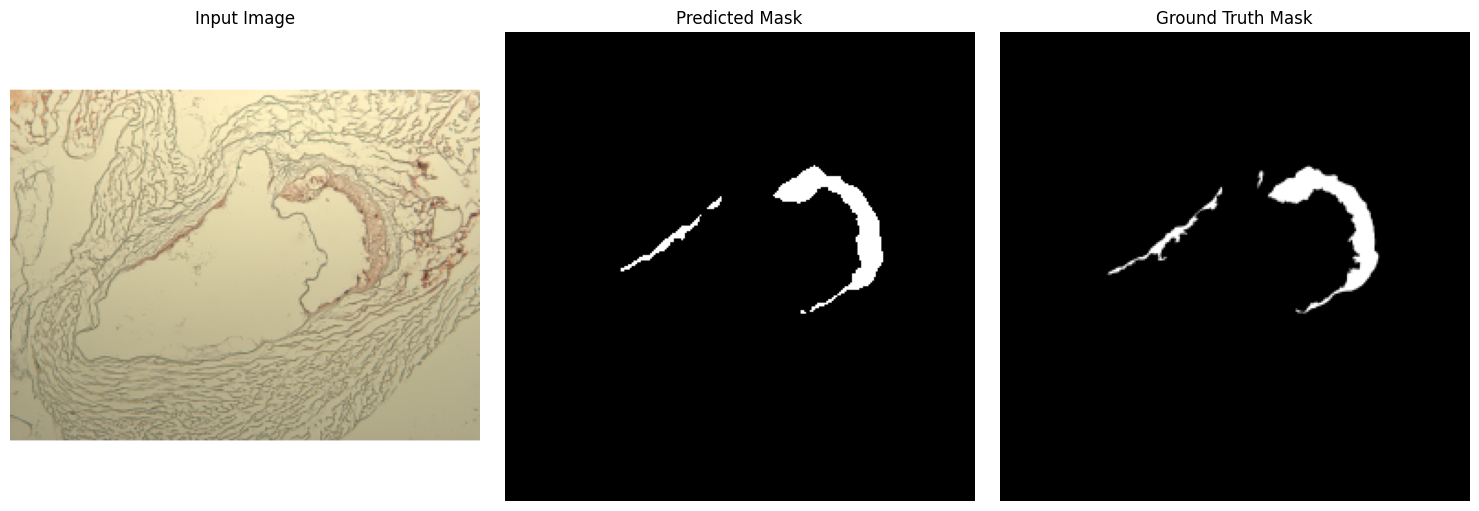

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))  # Wider figure for three images

# Subplot 1: Input Image
plt.subplot(1, 3, 1)
plt.imshow(x)
plt.title('Input Image')
plt.axis('off')

# Subplot 2: Predicted Mask
plt.subplot(1, 3, 2)
plt.imshow(y_pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

# Subplot 3: Ground Truth Mask
plt.subplot(1, 3, 3)
plt.imshow(y_true, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


# Segmentation Analysis

In [ ]:
#Overal Stats
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, jaccard_score, roc_auc_score

y_pred = unet.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)
y_true_bin = (y_test > 0.5).astype(np.uint8)

y_true_flat = y_true_bin.flatten()
y_pred_flat = y_pred_bin.flatten()


dice = f1_score(y_true_flat, y_pred_flat)

iou = jaccard_score(y_true_flat, y_pred_flat)

accuracy = accuracy_score(y_true_flat, y_pred_flat)

precision = precision_score(y_true_flat, y_pred_flat)
recall = recall_score(y_true_flat, y_pred_flat)


test_metrics = unet.evaluate(X_test, y_test)
print(f"Test Loss: {test_metrics[0]}, Test Dice Coefficient: {test_metrics[1]}")

print(f'Dice {dice}')
print(f'IOU {iou}')
print(f'Accuracy {accuracy}')
print(f'Precision {precision}')
print(f'Recall {recall}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - dice_coefficient: 0.8293 - loss: 0.1635
Test Loss: 0.17344991862773895, Test Dice Coefficient: 0.8085570931434631
Dice 0.8464969343106871
IOU 0.7338488812813302
Accuracy 0.9933567810058593
Precision 0.8531416347445401
Recall 0.8399549385653111


In [ ]:
#Stats for Each Test Image
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.astype(np.float32).flatten()
    y_pred_f = y_pred.astype(np.float32).flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_score(y_true, y_pred, smooth=1e-6):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return (intersection + smooth) / (union + smooth)

def pixel_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return (tp + smooth) / (tp + fp + smooth)

def recall_score(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return (tp + smooth) / (tp + fn + smooth)

dice_scores = []
iou_scores = []
pixel_accuracies = []
precisions = []
recalls = []

for x, y_true in zip(X_test, y_test):
    x_input = np.expand_dims(x, axis=0)
    pred = model.predict(x_input)[0]

    # Clean shapes
    pred = np.squeeze(pred)
    y_true = np.squeeze(y_true)

    pred_bin = (pred > 0.5).astype(np.uint8)
    y_true_bin = (y_true > 0.5).astype(np.uint8)

    dice_scores.append(dice_coefficient(y_true_bin, pred_bin))
    iou_scores.append(iou_score(y_true_bin, pred_bin))
    pixel_accuracies.append(pixel_accuracy(y_true_bin, pred_bin))
    precisions.append(precision_score(y_true_bin, pred_bin))
    recalls.append(recall_score(y_true_bin, pred_bin))




Text(0.5, 1.0, 'Dice vs. Mask Size')

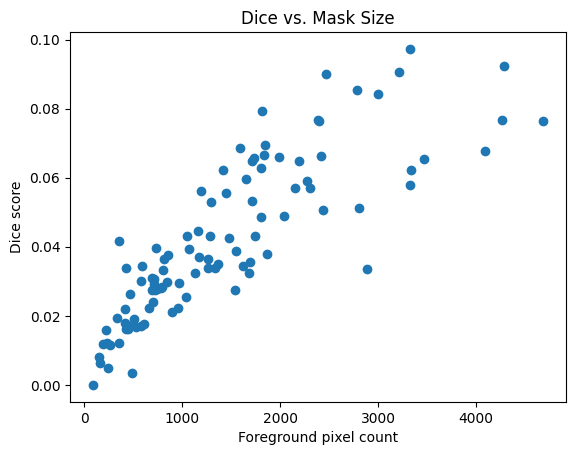

In [ ]:
mask_sizes = [np.sum(mask) for mask in y_test]
plt.scatter(mask_sizes, dice_scores)
plt.xlabel("Foreground pixel count")
plt.ylabel("Dice score")
plt.title("Dice vs. Mask Size")


In [ ]:
np.max(dice_scores)

np.float32(0.08645863)

# Lesion Size Quantification

# Quantification Analysis

# Final Results